<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Numerical convergence**

To demonstrate that the implementation of our numerical method is consistent, we test the convergence of our numerical approximation of the cdf, pdf and qdf against analytical expressions. For convinience we choose the function
\begin{equation}
Y(X) = \cos(X), \quad X \in [0, 2\pi],
\end{equation}
whose pdf, cdf and qdf (also known as the inverse cdf) are given by
\begin{equation}
f(y) = \frac{1}{\pi \sqrt{1 - y^2}}, \quad F(y) = 1 - \arccos(y)/\pi, \quad Q(p) = \cos(\pi(1-p)).
\end{equation}
Below we set up functions for these expressions.

In [25]:
from chist import Ptp
from firedrake import *

F = lambda y: 1 - acos(y)/np.pi
f = lambda y: 1/(np.pi*(1-y**2)**.5)
Q = lambda p: cos(np.pi*(1-p))

Varying the number of elements used we then compute the error between the numerical estimation provided by our method and its analytical expression. For the pdf we measure the error using the $L^1$ norm 
\begin{equation}
||f_{num} - f||_1 = \int_{\Omega} |f_{num}(y) -f(y)| dy,
\end{equation}
as $f(y)$ is not $L^2$ integrable, while for the cdf and qdf we choose the $L^2$ norm
\begin{equation}
||f_{num} - f||_2 = \int_{\Omega} |f_{num}(y) -f(y)|^2 dy.
\end{equation}
To ensure that the number of elements used becomes the leading order error we then choose large quadrature degree. 

In [26]:
error_cdf = []
error_pdf = []
error_qdf = []
Ne = [4, 8, 16, 32, 64, 128, 256]

def L1_norm(f):
    """Norm for computing the error."""
    return assemble( abs(f)*dx )

def L2_norm(f):
    """Norm for computing the error."""
    return assemble( (f**2)*dx )

for ne in Ne:

    # Compute the density object
    ptp = Ptp(Omega_X={'x1': (0, 2*np.pi)}, Omega_Y={'Y': (-1,1)}, n_elements=ne)
    x1 = ptp.x_coords()
    density = ptp.fit(Y=cos(x1), quadrature_degree=5000)
    
    # Compute the error for the cdf, pdf, qdf
    error_cdf.append( L2_norm(density.cdf - F(density.y)) )
    error_pdf.append( L1_norm(density.pdf - f(density.y)) )
    p = SpatialCoordinate(density.qdf.function_space().mesh())[0]
    error_qdf.append( L2_norm(density.qdf - Q(p)) )

    #density.plot('PDF')

Ne = np.asarray(Ne)
error_cdf = np.asarray(error_cdf)
error_pdf = np.asarray(error_pdf)
error_qdf = np.asarray(error_qdf)

Below we plot the rate of convergence, which for both the cdf and qdf is close to the theoretical estimate
\begin{equation}
||F_{num} - F||_2 \sim \mathcal{O}(N_e^{-(\alpha + 1)})
\end{equation}
which for a piecewise linear function space we take $\alpha=1$. For the pdf the slop is shallower
\begin{equation}
||f_{num} - f||_1 \sim \mathcal{O}(N_e^{-1/2})
\end{equation}
We have restricted the number of elements used to $N = 512$ as when a larger number of elements is used the slope reduces as errors due to quadrature become leading order.

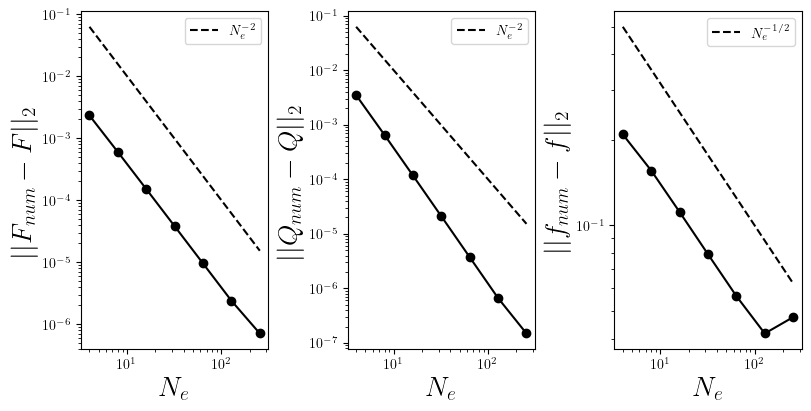

In [30]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
from firedrake.pyplot import plot


# Plot the convergence of the error
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4), layout='constrained')

# Theoretical convergence ~ O(N^2)
error = np.asarray([1./np.pow(n,2) for n in Ne ])

# CDF
ax[0].loglog(Ne,error_cdf,'k-')
ax[0].loglog(Ne,error_cdf,'ko')
ax[0].loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
ax[0].set_ylabel(r'$||F_{num} - F||_2$',fontsize=20)
ax[0].set_xlabel(r'$N_e$',fontsize=20)
ax[0].legend()

# QDF
ax[1].loglog(Ne,error_qdf,'k-')
ax[1].loglog(Ne,error_qdf,'ko')
ax[1].loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
ax[1].set_ylabel(r'$||Q_{num} - Q||_2$',fontsize=20)
ax[1].set_xlabel(r'$N_e$',fontsize=20)
ax[1].legend()

# Theoretical convergence ~ O(N^2)
error = np.asarray([1./np.pow(n,0.5) for n in Ne ])

# PDF
ax[2].loglog(Ne,error_pdf,'k-')
ax[2].loglog(Ne,error_pdf,'ko')
ax[2].loglog(Ne,error    ,'k--',label=r'$N_e^{-1/2}$')
ax[2].set_ylabel(r'$||f_{num} - f||_2$',fontsize=20)
ax[2].set_xlabel(r'$N_e$',fontsize=20)
ax[2].legend()

plt.show()